In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import phate

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT
from External.clustering import centers, k_means_pp, ICT_clusters, cfilter, cassign
from External.generation import create_graph, find_backbone
from External.plotting import plot_points, plot_graph, no_intersections
from External.reweight import reweight_clusters

from copy import deepcopy

# from External.create_k_nearest import patch_together

plt.style.use('standard.mplstyle')

In [5]:
# Hyperparameters
mode = "K_Nearest" # Graph construction mode
ICT_algorithm = "cluster_all"
metric = "euclidean" # metric for clustering

# Cluster rassignment
min_cluster_size = 12
small_behavior = "reassign" #reassign or remove

In [6]:
position, labels = phate.tree.gen_dla(n_dim=2, n_branch=3,
                                            branch_length=2500, rand_multiplier=2, seed=37, sigma=1)
position = StandardScaler().fit_transform(position)
number_of_nodes = len(position)

In [7]:
old_G, _ = create_graph(number_of_nodes, mode, position=position, beta=2, delta=0.5)
old_G.indexEdges()
cluster_centers2 = centers(position)


mst_G = deepcopy(old_G)

for u, v, w in mst_G.iterEdgesWeights():
    mst_G.setWeight(u, v, 1/w)

MST = nk.graph.RandomMaximumSpanningForest(mst_G)
MST.run()
MST = MST.getMSF(True)


MST.indexEdges()

Final k: 11


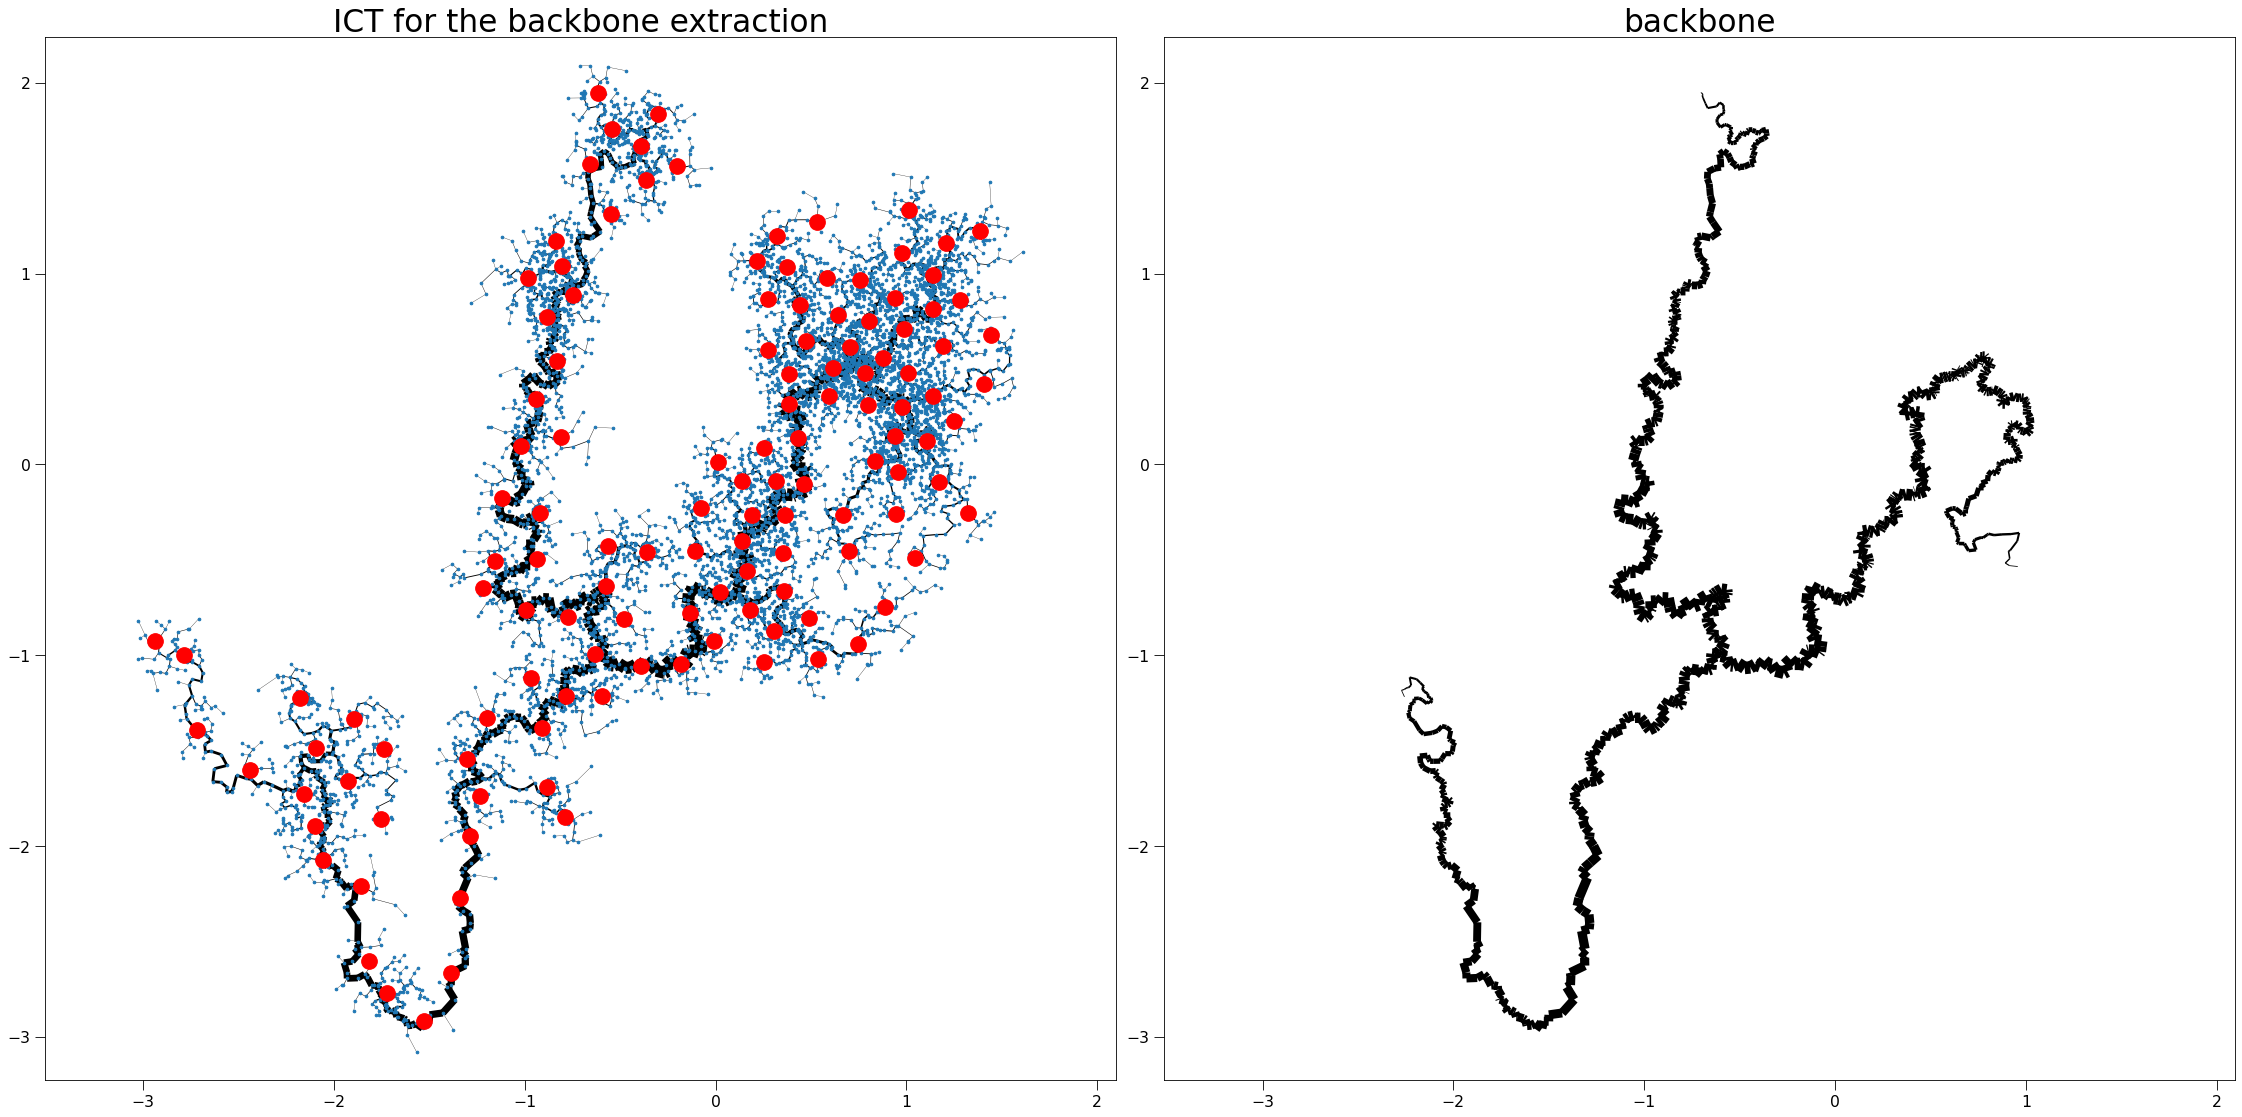

In [8]:
backbone, backbone_nodes = find_backbone(MST, number_of_vertices=1)
backbone.indexEdges()

# Plot the ICT
fig, axs = plt.subplots(1, 2)
plot_points(position, f"", axs[0], node_size=5)
axs[0].get_legend().remove()
plot_graph(MST, position, f"ICT for the backbone extraction", axs[0], cluster_centers=cluster_centers2, node_size=0)

plot_graph(backbone, position, f"backbone", axs[1], node_size=0)

plt.tight_layout()
plt.show()

create edgeId array:   0%|          | 0/48410 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/48410 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/7499 [00:00<?, ?it/s]

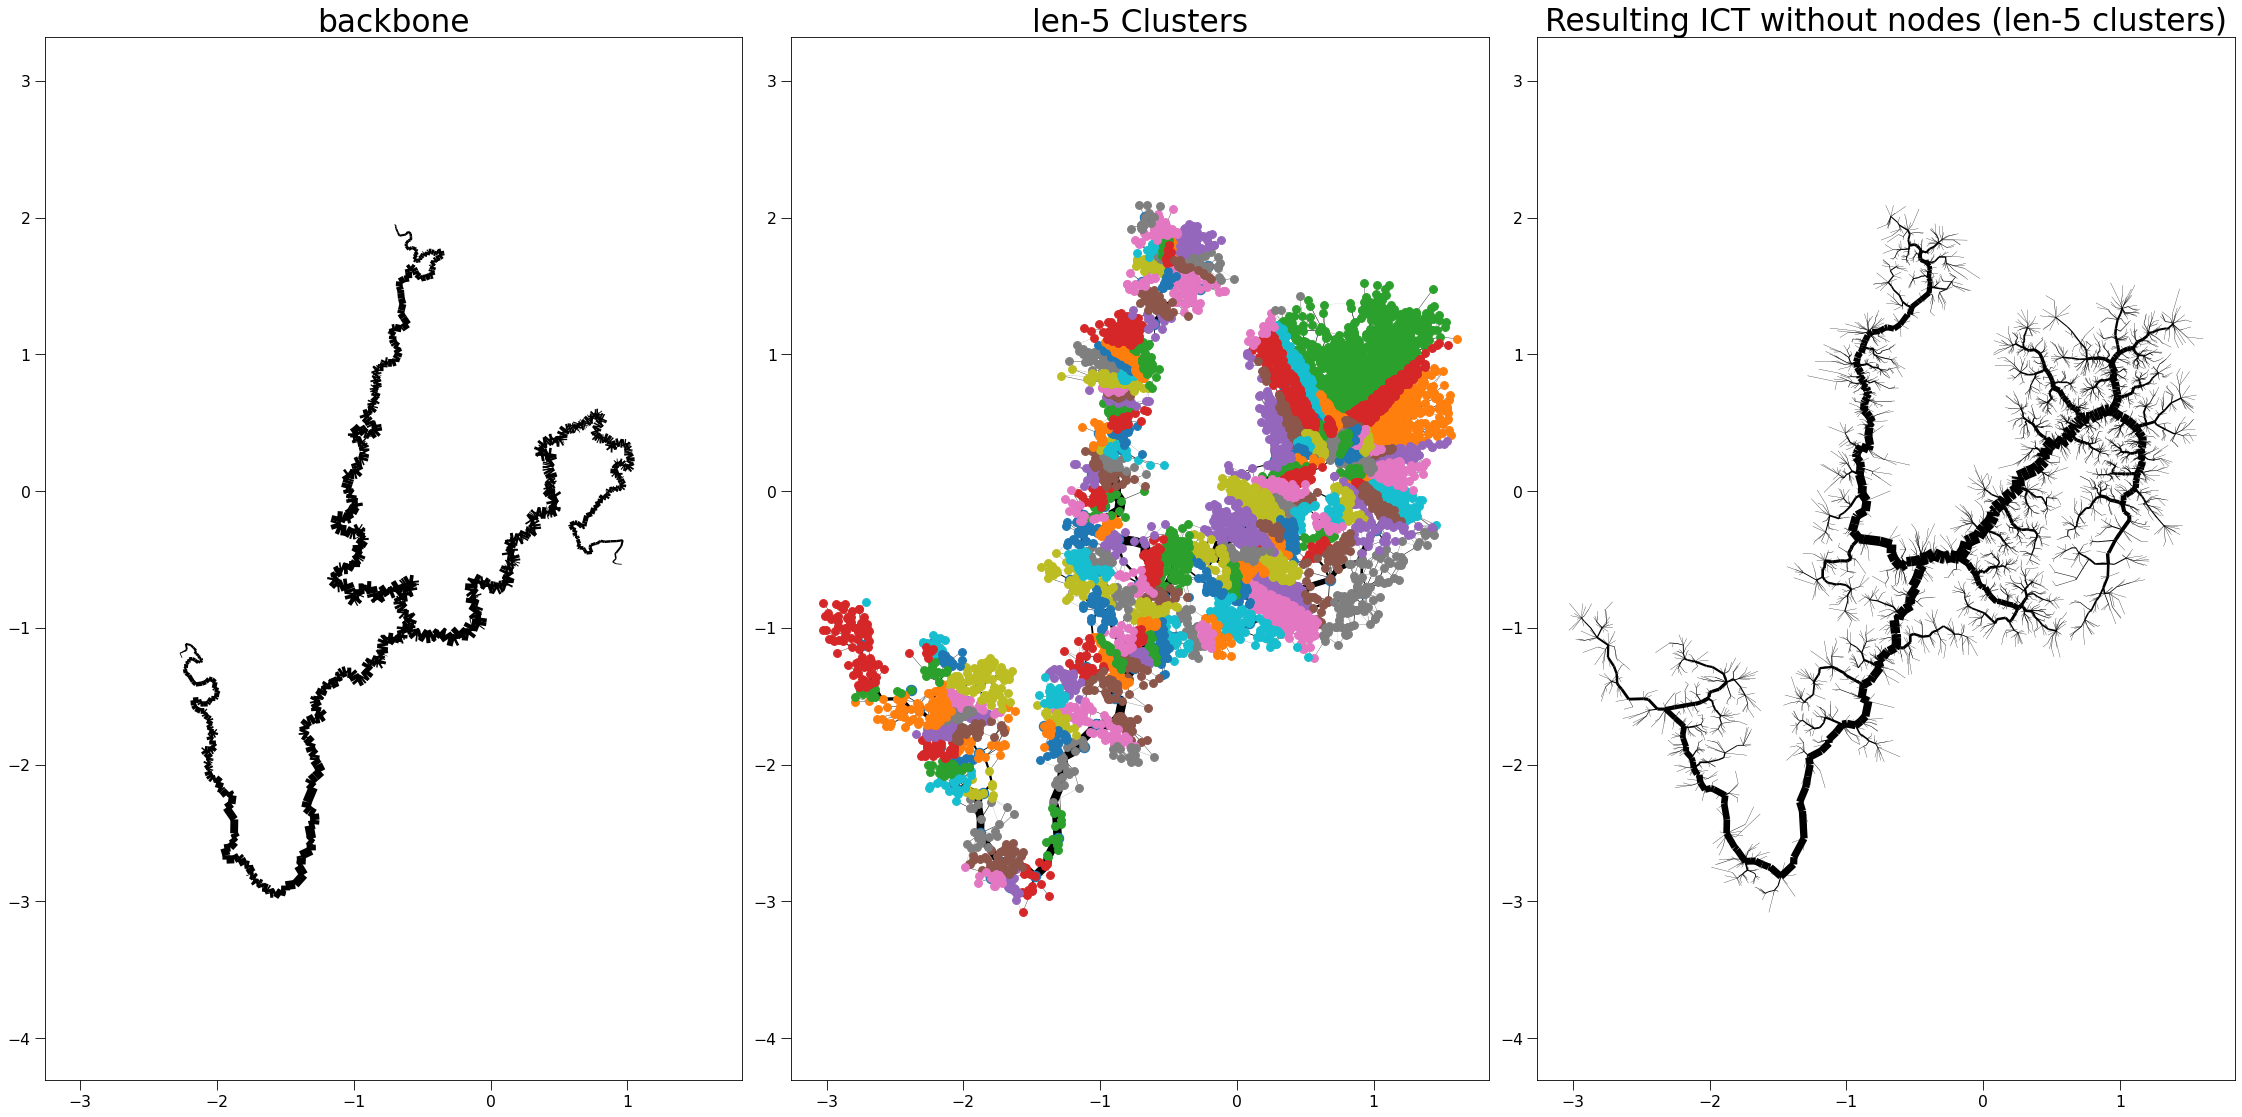

create edgeId array:   0%|          | 0/48410 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/48410 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/7499 [00:00<?, ?it/s]

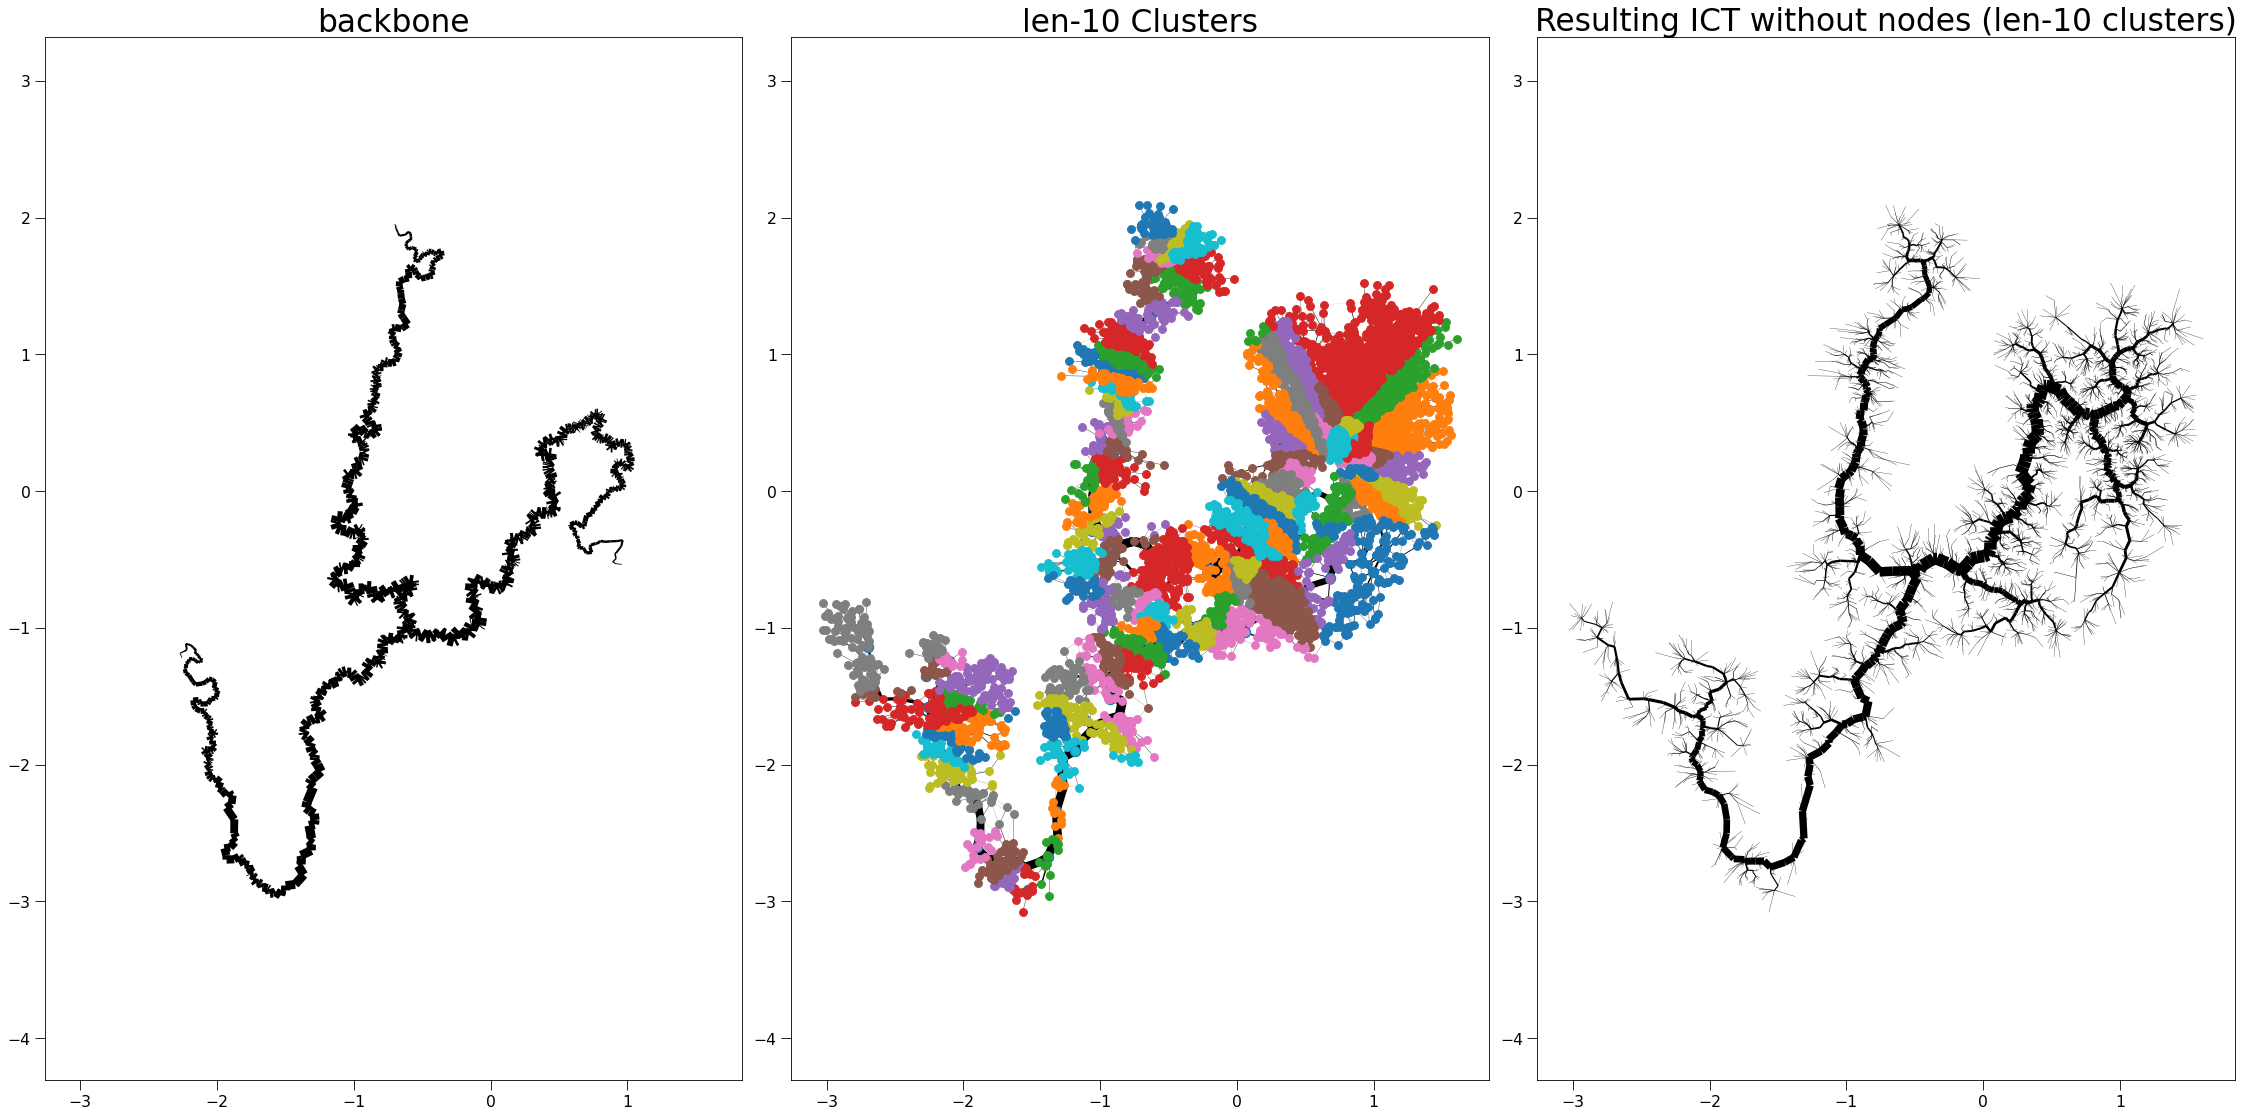

create edgeId array:   0%|          | 0/48410 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/48410 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/7499 [00:00<?, ?it/s]

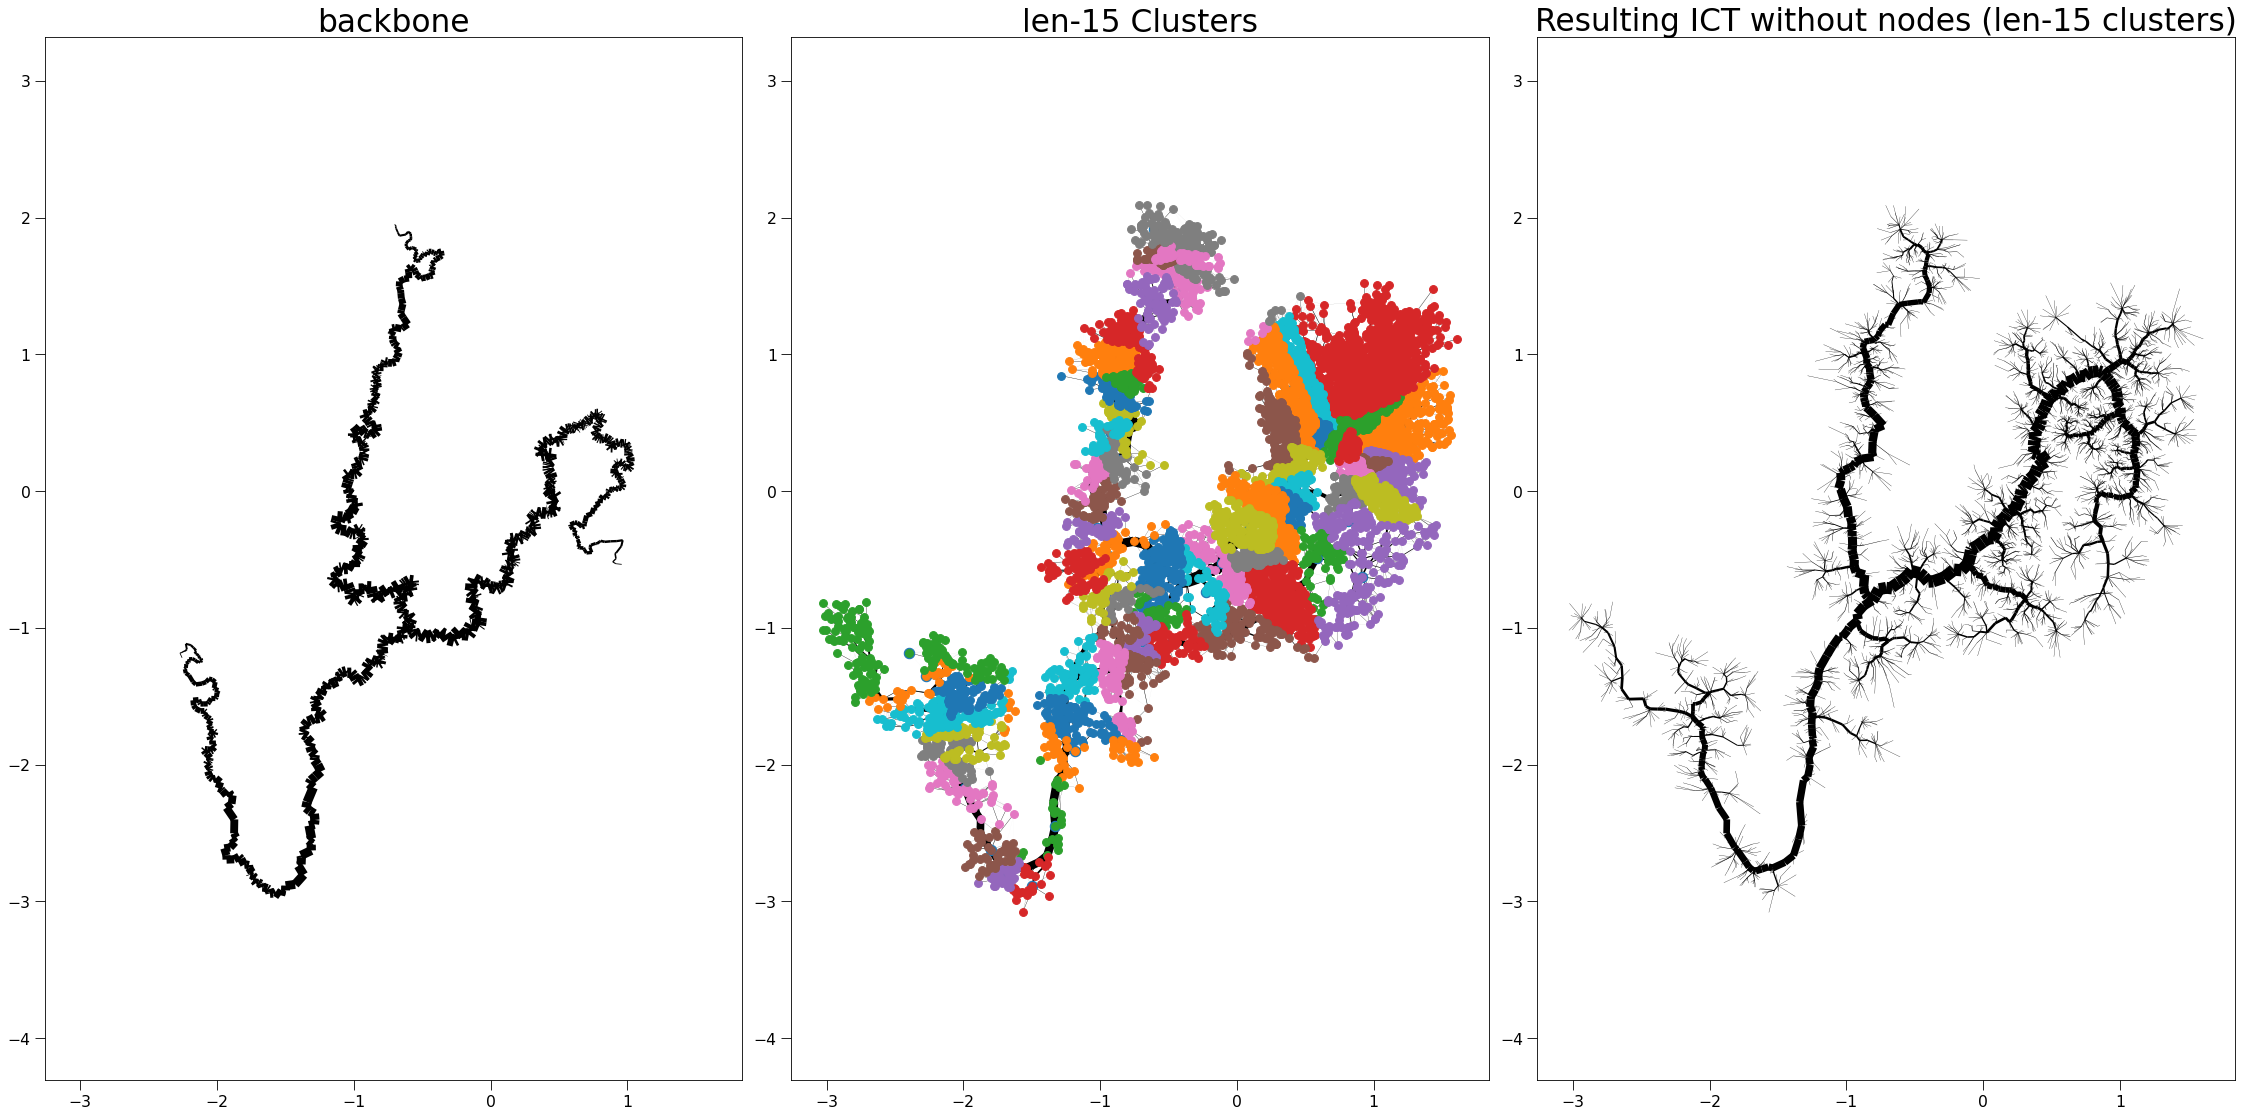

create edgeId array:   0%|          | 0/48410 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/48410 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/7499 [00:00<?, ?it/s]

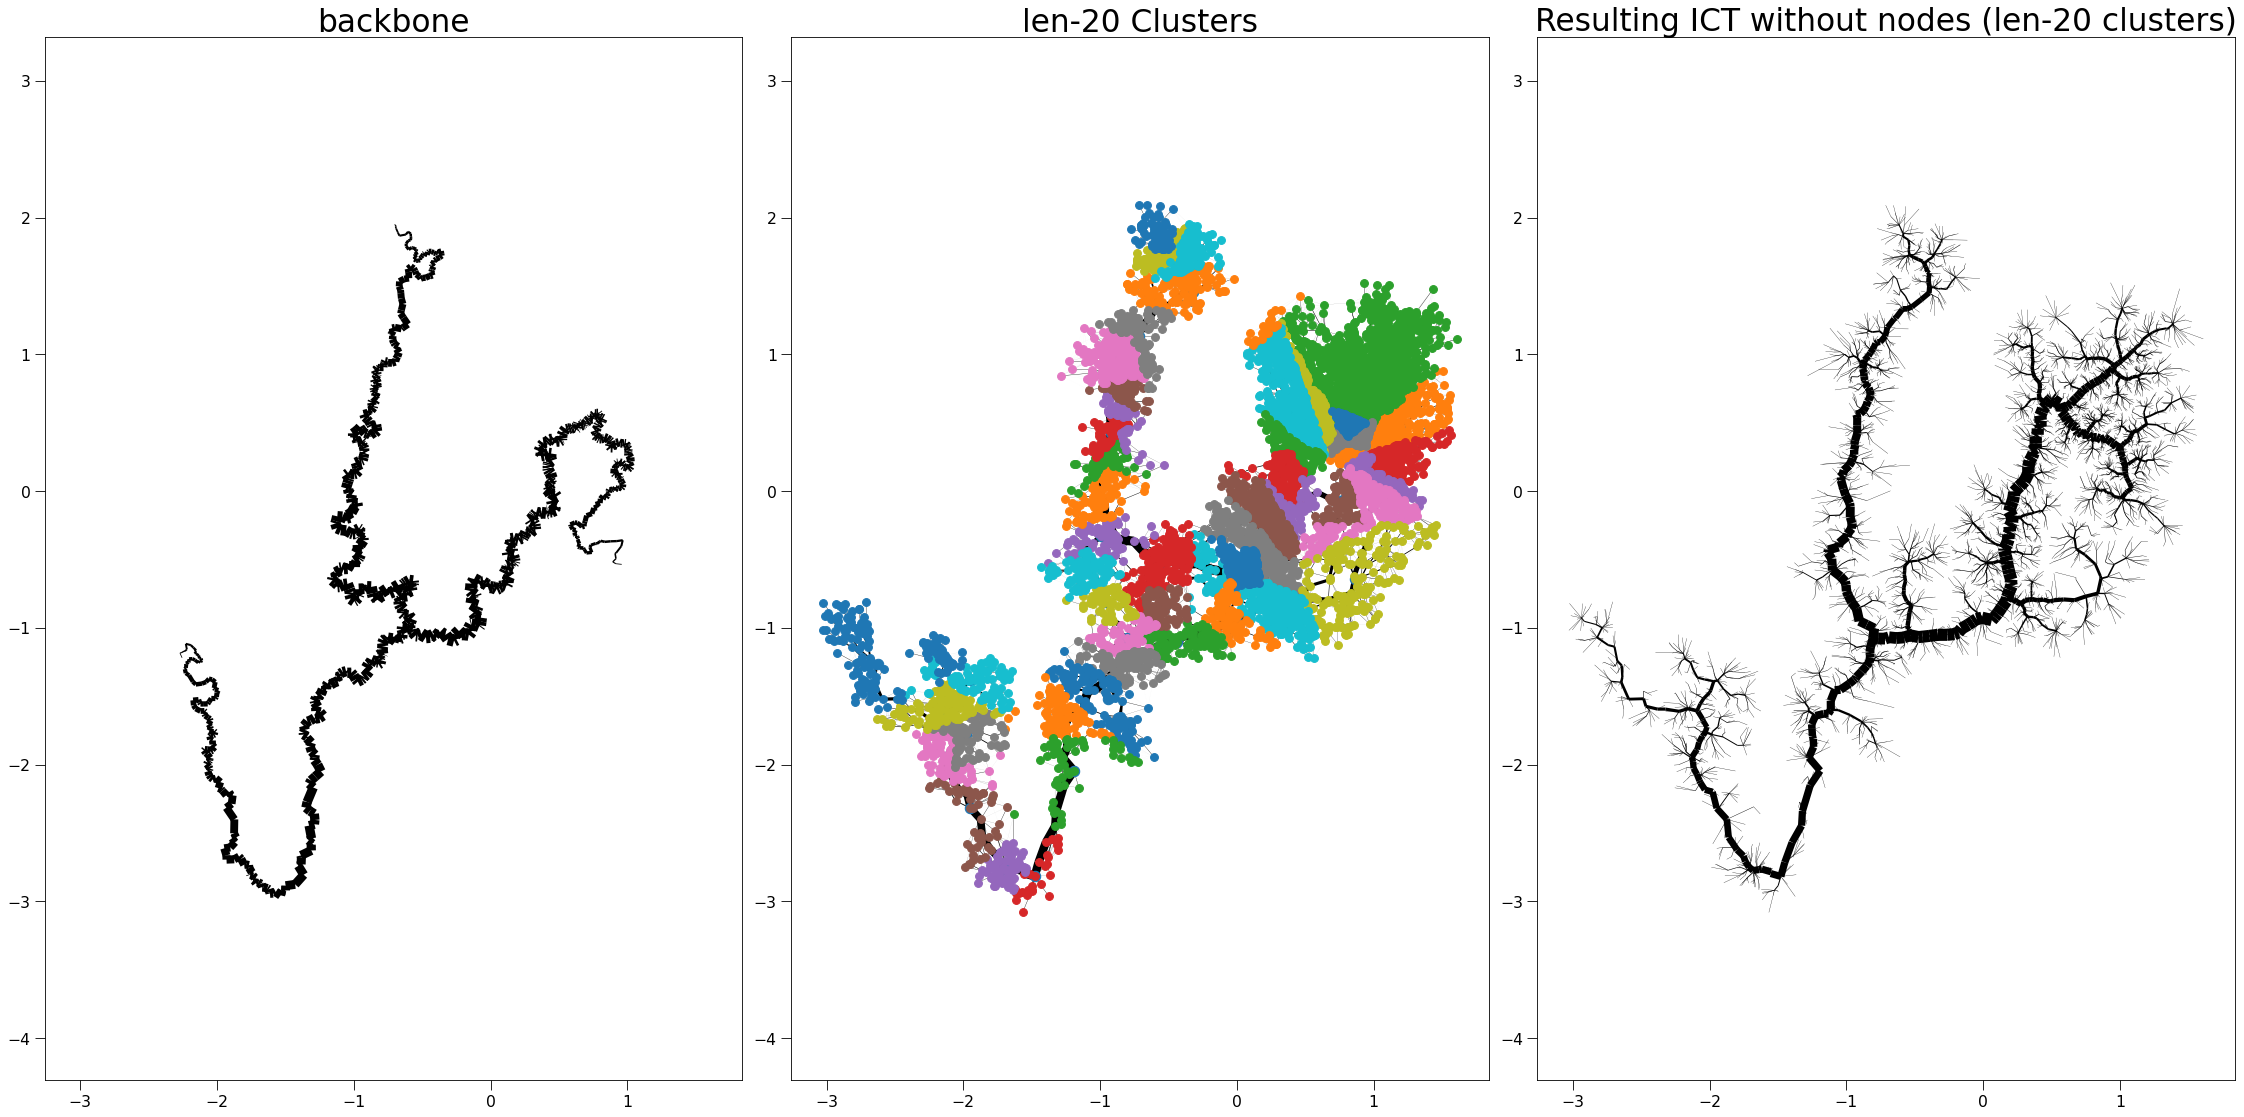

create edgeId array:   0%|          | 0/48410 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/48410 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/7499 [00:00<?, ?it/s]

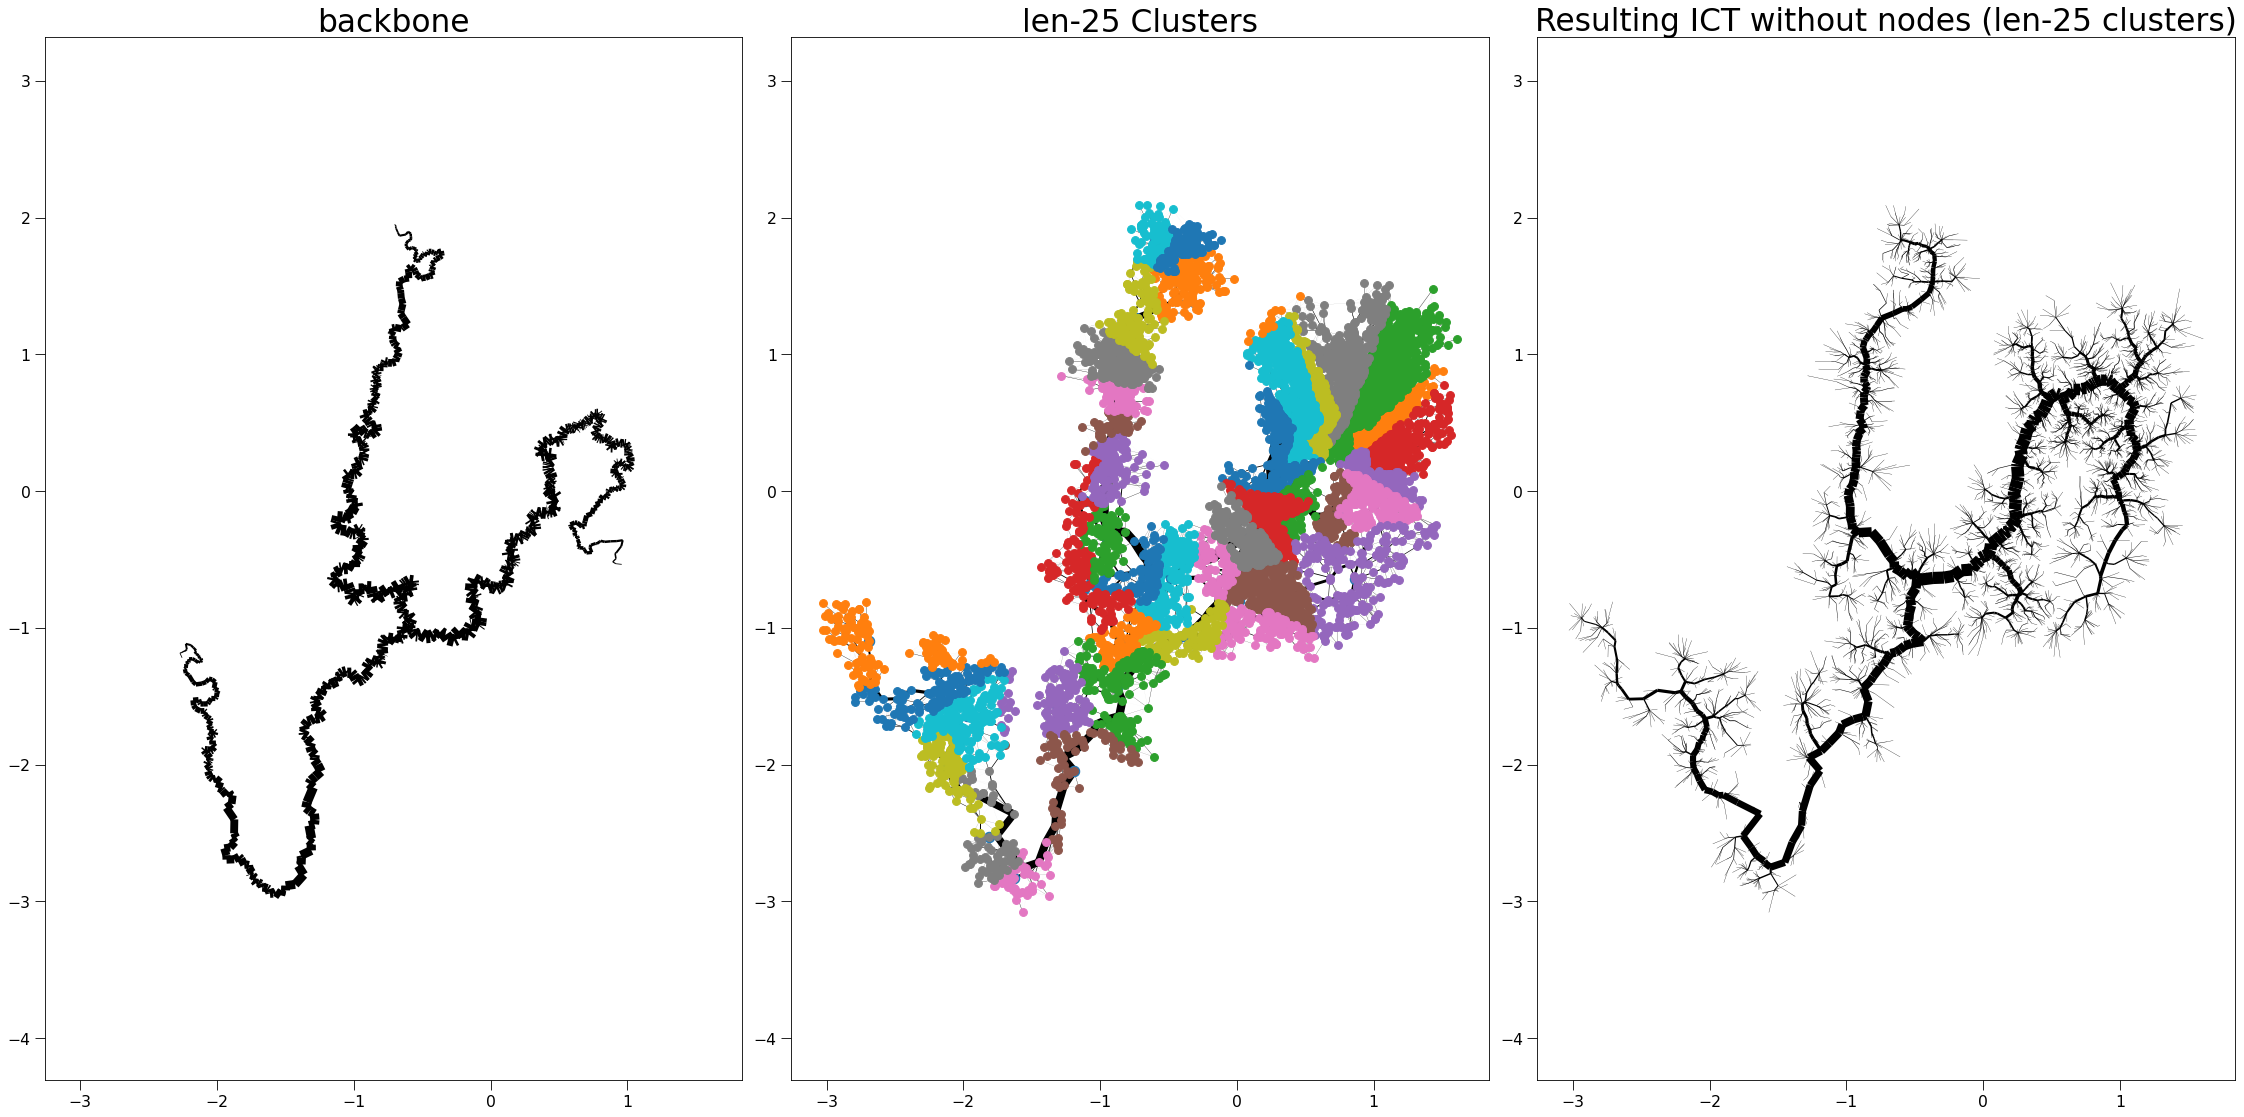

In [9]:
for k in range(5,30)[::5]:
    
    G = deepcopy(old_G)
    cluster_centers, cluster_labels = ICT_clusters(MST, position, number_of_vertices=1, avg_cluster_len=k, log=False)

    if small_behavior == "remove":
        cluster_centers, cluster_labels, (position, ) = cfilter(cluster_centers, cluster_labels, t=min_cluster_size, position_likes=[position])
        number_of_nodes = len(position)
    if small_behavior == "reassign":
        cluster_centers, cluster_labels = cassign(cluster_centers, cluster_labels, position, t=min_cluster_size)

    G = reweight_clusters(position, G, cluster_centers, cluster_labels, min_scale = 0.3, max_scale=1.1)
    
    G.indexEdges()
    
    ICT = calculate_ICT(G, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers2, zeros_stay_zeros=True, update_G=1.1)
        
    ICT.indexEdges()
    
    # Plot the ICT
    fig, axs = plt.subplots(1, 3)
    
    plot_graph(backbone, position, f"backbone", axs[0], node_size=0)
    
    plot_graph(G, position, f"", axs[1], node_size=0)
    plot_points(position[cluster_centers], f"", axs[1], node_size=20)
    plot_points(position, f"len-{k} Clusters", axs[1], labels=np.array(cluster_labels))
    axs[1].get_legend().remove()
    
    plot_graph(ICT, position, f"Resulting ICT without nodes (len-{k} clusters)", axs[2], node_size=0)
    name = str(k)
    plt.tight_layout()
    plt.savefig(f"Output/2D-Phate/no_density/" + name.zfill(5) + ".png")
    plt.show()